**Extraction des données**

In [2]:
# extraction des données du dossier compressé :
# import tarfile

# remplace "fichier.tar.gz" par le chemin de ton fichier
# with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as archive:
#     archive.extractall("dossier_de_sortie")  # décompresse tous les fichiers dans "dossier_de_sortie"
#     print(archive.getnames())  # Liste des fichiers extraits

/tmp/ipykernel_875/1433914472.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  archive.extractall("dossier_de_sortie")  # Décompresse tous les fichiers dans "dossier_de_sortie"
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



**Imports nécessaires**

In [32]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Création des datasets de train et test**

In [42]:
# version fonction

def create_datasets(dataset_type, polarity, base_path="dossier_de_sortie/aclImdb"):
    """
    Charge les reviews et les URLs correspondantes à partir des fichiers.
    
    :param dataset_type: 'train' ou 'test'
    :param polarity: 'pos' ou 'neg'
    :param base_path: Chemin de base vers les données (par défaut: "dossier_de_sortie/aclImdb")
    :return: DataFrame fusionné contenant les avis, les notes et les URLs associées
    """
    # chemins d'accès
    review_path = os.path.join(base_path, dataset_type, polarity)
    url_file = os.path.join(base_path, dataset_type, f"urls_{polarity}.txt")

    # chargement des fichiers texte et stockage dans une liste
    data = []
    for fichier in os.listdir(review_path):
        if fichier.endswith(".txt"):  
            chemin_fichier = os.path.join(review_path, fichier)
            with open(chemin_fichier, "r", encoding="utf-8") as f:
                contenu = f.read()
            data.append((fichier, contenu))

    # conversion en dataframe
    df_reviews = pd.DataFrame(data, columns=["fichier", "review"])
    df_reviews[["id_review", "note"]] = df_reviews["fichier"].str.replace(".txt", "", regex=False).str.split("_", expand=True)
    df_reviews = df_reviews.drop("fichier", axis=1)

    # ajout des urls pour chaque review
    df_urls = pd.read_csv(url_file, header=None, names=['url'])
    df_urls['id_imdb_movie'] = df_urls['url'].str.extract(r'(tt\d+)')
    merged_df = pd.concat([df_reviews, df_urls], axis=1)

    return merged_df


merged_test_neg = create_datasets(dataset_type="test", polarity="neg")
merged_test_pos = create_datasets(dataset_type="test", polarity="pos")
merged_train_neg = create_datasets(dataset_type="train", polarity="neg")
merged_train_pos = create_datasets(dataset_type="train", polarity="pos")

In [43]:
print(len(pd.unique(merged_test_neg['id_imdb_movie']))) # nombre de films dans la moitié négative de la base test
len(merged_test_neg) # nombre de reviews

3016


12500

In [44]:
# Création des datasets de test et train complets par merge des datasets de test/train pos et neg
test = pd.concat([merged_test_pos, merged_test_neg], ignore_index=True)
train = pd.concat([merged_train_pos, merged_train_neg], ignore_index=True)

In [36]:
print(len(pd.unique(test['id_imdb_movie']))) # nombre de films dans la base test
len(test) # nombre de reviews

3581


25000

In [45]:
# version shuffled ?
test_mix = test.sample(frac=1, random_state=42).reset_index(drop=True)
train_mix = train.sample(frac=1, random_state=42).reset_index(drop=True)
test_mix.head()

,review,id_review,note,url,id_imdb_movie
0,This is without a doubt one of Neil Simon's be...,6742,10,http://www.imdb.com/title/tt0077699/usercomments,tt0077699
1,This show drives me crazy. It goes against eve...,3293,3,http://www.imdb.com/title/tt0463903/usercomments,tt0463903
2,I found the film Don't Look In The Basement to...,749,7,http://www.imdb.com/title/tt0182576/usercomments,tt0182576
3,I have been a huge Lynn Peterson fan ever sinc...,1790,2,http://www.imdb.com/title/tt0367623/usercomments,tt0367623
4,It's hard to decide what to say about this one...,1459,4,http://www.imdb.com/title/tt0202382/usercomments,tt0202382


**Observation des données**

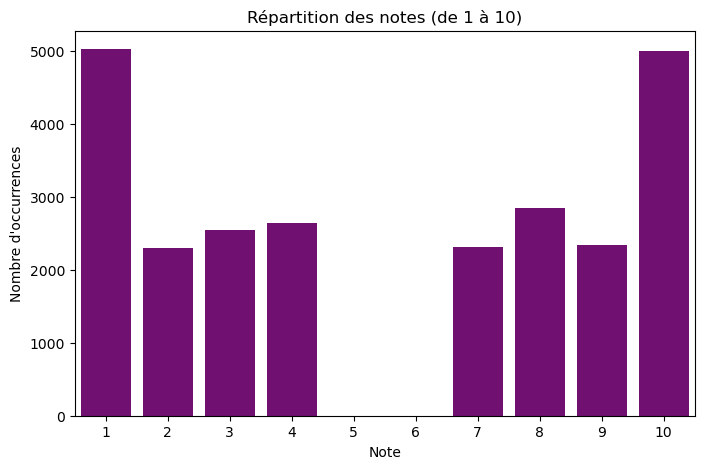

In [46]:
# Répartition des notes dans le test set
plt.figure(figsize=(8, 5))
sns.countplot(data=test_mix, x="note", color="purple", order=range(1, 11))
plt.xlabel("Note")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des notes (de 1 à 10)")
plt.show()

In [47]:
# Recodages des labels

test_mix['note'] = test_mix['note'].astype(int)

# sentiment en binaire
test_mix['note_bin'] = test_mix['note'].apply(lambda x: 0 if x <= 4 else (1 if x >= 7 else x))

# sentiment plus précis
mapping = {
    1: 'Very Negative', 2: 'Very Negative',
    3: 'Negative', 4: 'Negative',
    7: 'Positive', 8: 'Positive', 
    9: 'Very Positive', 10: 'Very Positive'
}
test_mix['note_prec'] = test_mix['note'].replace(mapping)

# modification des urls, la terminaison 'usercomments' ne sert pas
test_mix['url'] = test_mix['url'].str.replace('usercomments', '', regex=False)
test_mix['url'] = test_mix['url'].str.replace('http://', 'https://', regex=False)

test_mix.head(10)

,review,id_review,note,url,id_imdb_movie,note_bin,note_prec
0,This is without a doubt one of Neil Simon's be...,6742,10,https://www.imdb.com/title/tt0077699/,tt0077699,1,Very Positive
1,This show drives me crazy. It goes against eve...,3293,3,https://www.imdb.com/title/tt0463903/,tt0463903,0,Negative
2,I found the film Don't Look In The Basement to...,749,7,https://www.imdb.com/title/tt0182576/,tt0182576,1,Positive
3,I have been a huge Lynn Peterson fan ever sinc...,1790,2,https://www.imdb.com/title/tt0367623/,tt0367623,0,Very Negative
4,It's hard to decide what to say about this one...,1459,4,https://www.imdb.com/title/tt0202382/,tt0202382,0,Negative
5,"""you can't take it realistically."" -sheets<br ...",6937,7,https://www.imdb.com/title/tt0124901/,tt0124901,1,Positive
6,This is another one of those films that I reme...,8864,10,https://www.imdb.com/title/tt0902306/,tt0902306,1,Very Positive
7,The scientist Charles and his wife (or assista...,5405,2,https://www.imdb.com/title/tt0808151/,tt0808151,0,Very Negative
8,Batman Returns is more Gothic and somber than ...,7983,10,https://www.imdb.com/title/tt0088583/,tt0088583,1,Very Positive
9,A brilliant Sherlock Holmes adventure starring...,9419,10,https://www.imdb.com/title/tt0218839/,tt0218839,1,Very Positive


In [48]:
test_mix.to_csv("test_mix.csv", index=True)  # enregistrement du dataset de test (shuffled)

In [49]:
test_mix = pd.read_csv('test_mix.csv')
test_mix.columns

Index(['Unnamed: 0', 'review', 'id_review', 'note', 'url', 'id_imdb_movie',
       'note_bin', 'note_prec'],
      dtype='object')

In [ ]:
# à faire :
# la moyenne des notes sur chaque film, la variance et l'écart-type => est-ce que les reviews sont très contrastées sur chaque film ?
# nombre de reviews par film en moyenne (vérifier qu'on est pas à plus de 30 pour chaque, mais c'est quoi la répartition exacte ? car il n'y a pas 30 reviews par film)
# appliquer le modèle BERT pour constater un haut niveau d'accuracy